In [54]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


<ipython-input-55-ef1c95928b8c>:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data DA/Dữ liệu Lịch sử HSG.csv')

In [58]:
# Rename columns
df.rename(columns={"Ngày":"Date","Lần cuối":"Close","Mở":"Open","Cao":"High","Thấp":"Low","KL": "Volume","% Thay đổi": "percent_change"}, inplace= True)

In [59]:
# Checking null value
df.isnull().sum()

Date              0
Close             0
Open              0
High              0
Low               0
Volume            0
percent_change    0
dtype: int64

In [60]:
df.dtypes

Date              object
Close             object
Open              object
High              object
Low               object
Volume            object
percent_change    object
dtype: object

In [61]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Volume'] = df['Volume'].apply(convert_to_number)
  df['percent_change'] = df['percent_change'].apply(lambda x: float(x.strip('%'))/100)

In [62]:
tranformData(df)
df

,Date,Close,Open,High,Low,Volume,percent_change
0,2023-05-24,15750.0,16100.0,16100.0,15650.0,10890000.0,-0.0125
1,2023-05-23,15950.0,16150.0,16300.0,15850.0,14910000.0,-0.0124
2,2023-05-22,16150.0,15600.0,16300.0,15600.0,20020000.0,0.0386
3,2023-05-19,15550.0,15500.0,15750.0,15400.0,6170000.0,0.0065
4,2023-05-18,15450.0,15600.0,15700.0,15450.0,8700000.0,-0.0032
...,...,...,...,...,...,...,...
1359,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
1360,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
1361,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
1362,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688


In [63]:
df.dtypes

Date              datetime64[ns]
Close                    float64
Open                     float64
High                     float64
Low                      float64
Volume                   float64
percent_change           float64
dtype: object

In [64]:
df=df.set_index('Date')
df = df.sort_index()
df

,Close,Open,High,Low,Volume,percent_change
Date,,,,,,
2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...
2023-05-18,15450.0,15600.0,15700.0,15450.0,8700000.0,-0.0032
2023-05-19,15550.0,15500.0,15750.0,15400.0,6170000.0,0.0065
2023-05-22,16150.0,15600.0,16300.0,15600.0,20020000.0,0.0386


In [65]:
fig = px.line(df, x=df.index, y=df.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of HSG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [66]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int(len(df) * 0.7)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
df=df['Close']

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện: ", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra: ", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện:  (954,)
Số lượng mẫu trong tập kiểm tra:  (272,)
Số lượng mẫu trong tập valid:  (138,)


In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

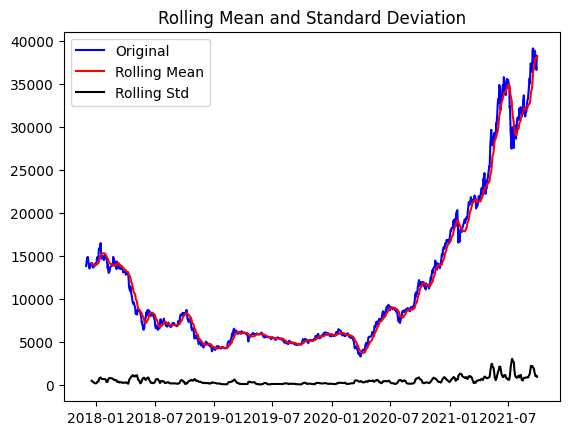

Results of dickey fuller test
Test Statistics                  1.743211
p-value                          0.998229
No. of lags used                21.000000
Number of observations used    932.000000
critical value (1%)             -3.437386
critical value (5%)             -2.864646
critical value (10%)            -2.568424
dtype: float64


In [68]:
test_stationarity(train_data)

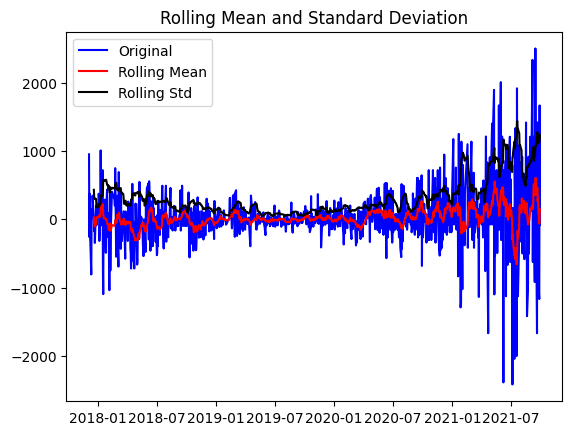

Results of dickey fuller test
Test Statistics               -5.808269e+00
p-value                        4.463322e-07
No. of lags used               2.000000e+01
Number of observations used    9.320000e+02
critical value (1%)           -3.437386e+00
critical value (5%)           -2.864646e+00
critical value (10%)          -2.568424e+00
dtype: float64


In [69]:
train_data_diff = train_data.diff().dropna()
test_stationarity(train_data_diff)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



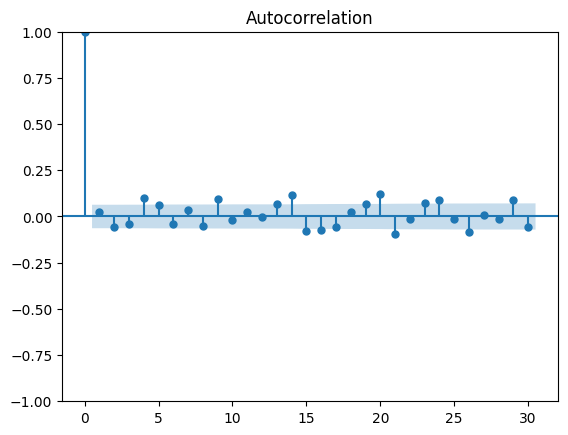

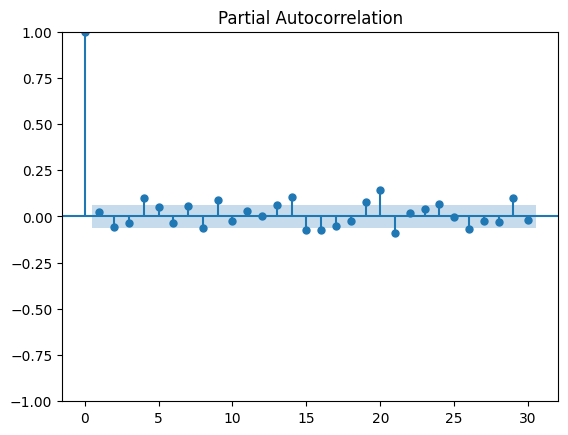

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(train_data_diff)

pacf_original = plot_pacf(train_data_diff)

In [71]:
from pmdarima.arima import auto_arima
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)
model = auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=False, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14258.587, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14259.319, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14259.154, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14259.992, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14260.581, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.606 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  954
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7127.293
Date:                Sat, 27 May 2023   AIC                          14258.587
Time:                        05:25:05   BIC                          14268.306
Sample:                             0   HQIC                         14262.289
                                - 954                                  

In [72]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [73]:
last_date=val_data.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(forecast_df))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[38275.62381952 38301.24763903 38326.87145855 38352.49527807
 38378.11909759 38403.7429171  38429.36673662 38454.99055614
 38480.61437566 38506.23819517 38531.86201469 38557.48583421
 38583.10965373 38608.73347324 38634.35729276 38659.98111228
 38685.60493179 38711.22875131 38736.85257083 38762.47639035
 38788.10020986 38813.72402938 38839.3478489  38864.97166842
 38890.59548793 38916.21930745 38941.84312697 38967.46694648
 38993.090766  ]


In [76]:
for i in range(len(forecast_df)):
    forecast_df.loc[i, 'Close'] = y_next_30_days[i]

In [77]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 26175.070587894836
Testing RMSE: 20316.246320448176


Validation RMSE: 26175.070587894836
Testing RMSE: 20316.246320448176


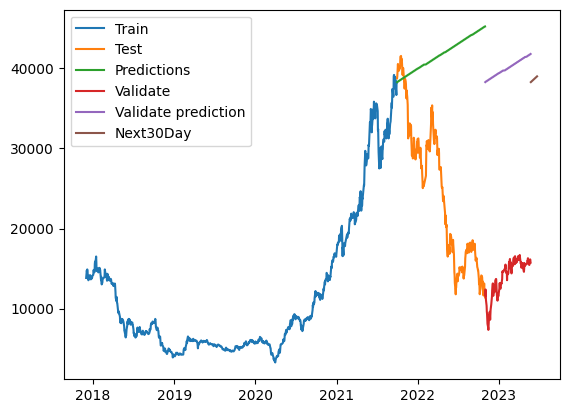

In [78]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data)
plt.plot(val_data.index, y_pred_val)
plt.plot(forecast_df.Date,forecast_df.Close)
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate prediction','Next30Day'])
plt.show()